In [1]:
import os
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.linalg import svd

In [2]:
folders = [x[0] for x in os.walk('images')][1:]

In [3]:
images = []
# set image size to 20 x 20, because my pc is slow.
# You can easily change image size and everything will work fine.
image_size = (20, 20)
for folder in folders:
    with open(folder+'/filelist_LBP.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for img_name, left, top, right, bottom, new_size_y, new_size_x in reader:
            img = Image.open(folder+'/'+img_name).resize((int(new_size_y), int(new_size_x))).crop((int(left), int(top), int(right), int(bottom))).resize(image_size)
            images.append(img)

Showing few random faces from the dataset.

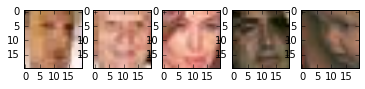

In [4]:
for i in range(1, 6):
    img = random.choice(images)
    plt.subplot(2, 5, i)
    plt.imshow(img)

### Implementing eigenfaces with SVD

Implement eigenfaces using singular value decomposition (SVD). Remember to represent the images properly and account for the color.

In [5]:
# =============== TODO: Your code here ===============
# Represent the images as a matrix for SVD decompotision.
rgb_image_shape = image_size + (3, )

color_images_matrix = [np.asarray(image) for image in images if np.asarray(image).shape == rgb_image_shape]
grey_images = [image for image in images if np.asarray(image).shape != rgb_image_shape]

for image in grey_images:
    rgb_image = Image.new("RGB", image_size)
    rgb_image.paste(image)
    color_images_matrix.append(np.asarray(rgb_image))

flatten_images_shape = (rgb_image_shape[0] * rgb_image_shape[1] * rgb_image_shape[2])
X = np.reshape(color_images_matrix, (len(color_images_matrix), flatten_images_shape))
# ====================================================

In [6]:
num_faces = 10

In [7]:
mean_face = np.mean(X, axis=0)
X = X - mean_face
X.shape

(14233, 1200)

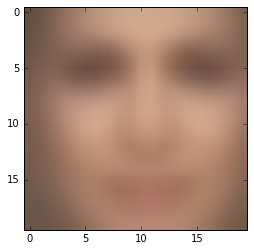

In [8]:
plt.imshow(np.array(mean_face, dtype='uint8').reshape(rgb_image_shape))

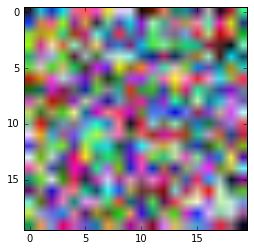

In [9]:
plt.imshow(np.array(mean_face, dtype="float64").reshape(rgb_image_shape))

In [10]:
def plot_eigenfaces(eigenvectors, num_faces=num_faces):
    plt.figure(figsize=(20,10))
    for i in range(1, num_faces+1):
        img = eigenvectors[i - 1]
        plt.subplot(2, 10, i)
        plt.imshow(np.array(img).reshape(rgb_image_shape))

In [11]:
# =============== TODO: Your code here ===============
# Implement eigenfaces using singular value decomposition (SVD). 
# Remember to represent the images properly and account for the color.
cov_matrix = np.cov(X.T)
cov_matrix.shape

(1200, 1200)

#### I tried 3 different ways of finding eigenfaces to compare results. Either of them are applicable.

1) SVD using TruncatedSVD

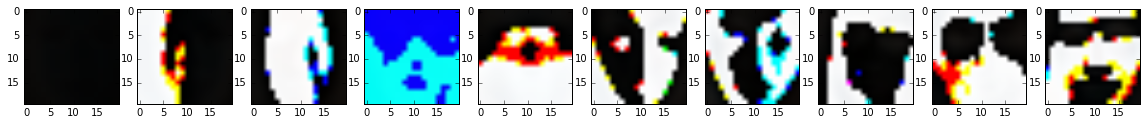

In [12]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = num_faces)
svd.fit(cov_matrix)
eigenvectors = svd.components_

plot_eigenfaces(eigenvectors)

2) Using eigh from scipy

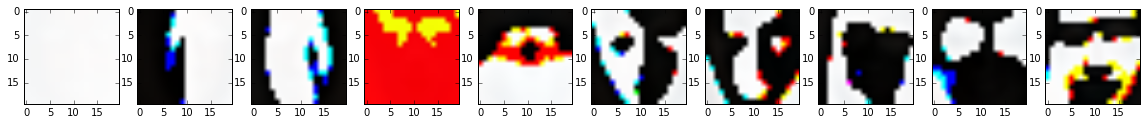

In [13]:
from scipy.linalg import eigh
# solve an eigenvalue prolem. Get only 10 largest eigenvalues
eigenvalues, eigenvectors = eigh(cov_matrix, eigvals=(cov_matrix.shape[0] - 10, cov_matrix.shape[0] - 1))

# sort in descending order
indices = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[indices]
eigenvectors = eigenvectors[:, indices]

plot_eigenfaces(eigenvectors.T)

3) Using PCA from OpenCV

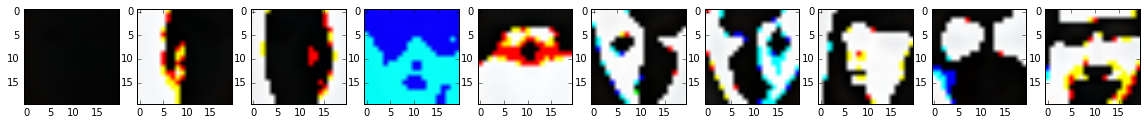

In [14]:
import cv2
mean, eigenvectors = cv2.PCACompute(X, mean=None, maxComponents=10)

plot_eigenfaces(eigenvectors)

Visualize 10 eigenfaces associated with the highest eigenvalues.

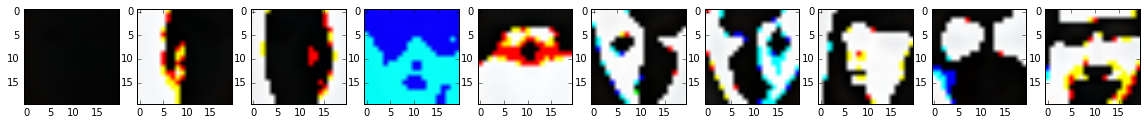

In [15]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces associated with the highest eigenvalues.
plot_eigenfaces(eigenvectors)
# ====================================================

### Implementing eigenfaces with variance maximization

As you have noticed, SVD could be quite slow if the number of faces is large. If the number of faces exceeds 50k, which is not a large dataset according to the modern standards, doing SVD is not possible directly and you have to use iterative methods for computing eigenfaces.

Here, you are going to calculate 10 eigenfaces by maximizing variance as stated in the lecture notes.

Inspired by https://web.stanford.edu/class/cs168/l/l8.pdf and http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf

Instead of using Lagrange multiplier will normalize `w` after each step.

In [16]:
# =============== TODO: Your code here ===============
# Calculate 10 eigenfaces iteratively by variance maximization.
from copy import deepcopy

# Find first eigenvector using variance maximization
def learn_eigenvector(cov_matrix, epsilon, alpha=0.1):
    convergence = False
    iteration = 0
    loss_history = []
    w = np.random.sample(cov_matrix.shape[0])
    w = w / np.linalg.norm(w)

    while not convergence:
        previous_w = deepcopy(w)

        # gradient descent
        w += alpha * (2 * cov_matrix.dot(w))
        w = w / np.linalg.norm(w)

        # calc loss as norm of w - previous_w
        loss = np.linalg.norm(w - previous_w)    
        if loss_history and abs(loss - loss_history[-1]) < epsilon:
            convergence = True

        iteration += 1
        loss_history.append(loss)

        print("Iteration: {0:2d}    Loss: {1:.4f}".format(iteration, loss))
    
    return w

first_eigenvector = learn_eigenvector(cov_matrix, epsilon=0.0001)
# ====================================================

Iteration:  1    Loss: 0.5474
Iteration:  2    Loss: 0.0640
Iteration:  3    Loss: 0.0379
Iteration:  4    Loss: 0.0225
Iteration:  5    Loss: 0.0133
Iteration:  6    Loss: 0.0079
Iteration:  7    Loss: 0.0047
Iteration:  8    Loss: 0.0028
Iteration:  9    Loss: 0.0016
Iteration: 10    Loss: 0.0010
Iteration: 11    Loss: 0.0006
Iteration: 12    Loss: 0.0003
Iteration: 13    Loss: 0.0002
Iteration: 14    Loss: 0.0001


In [17]:
first_eigenvector

array([0.035499  , 0.03124336, 0.02719099, ..., 0.01665855, 0.01645188,
       0.01552796])

In [18]:
eigenvectors[:, 0]

array([ 0.03550421, -0.0304128 , -0.04739015,  0.02894437,  0.04825006,
       -0.01298499, -0.00564827, -0.06329299,  0.05585832,  0.05006045])

Find another 9 eigenvectors

In [19]:
project_orthogonally = np.dot(np.dot(X, first_eigenvector)[:, np.newaxis], first_eigenvector[np.newaxis, :])

In [20]:
X_projected_on_first_eigenvector = X - project_orthogonally

In [21]:
X_projected_on_first_eigenvector.shape

(14233, 1200)

In [22]:
new_cov = np.cov(X_projected_on_first_eigenvector.T)
second_eigenvector = learn_eigenvector(new_cov, epsilon=0.0001, alpha=0.1)

Iteration:  1    Loss: 1.2410
Iteration:  2    Loss: 0.0615
Iteration:  3    Loss: 0.0202
Iteration:  4    Loss: 0.0089
Iteration:  5    Loss: 0.0043
Iteration:  6    Loss: 0.0021
Iteration:  7    Loss: 0.0011
Iteration:  8    Loss: 0.0005
Iteration:  9    Loss: 0.0003
Iteration: 10    Loss: 0.0001
Iteration: 11    Loss: 0.0001


In [23]:
second_eigenvector

array([-0.03041587, -0.02482502, -0.02010789, ...,  0.02980867,
        0.02509402,  0.0216205 ])

In [24]:
eigenvectors[:, 1]

array([ 0.03124761, -0.02482248, -0.0442613 , -0.00058886,  0.04250242,
       -0.0121895 , -0.00357615, -0.05690192,  0.04691484,  0.04879371])

In [25]:
iterative_eigenvectors = []
iterative_eigenvectors.append(first_eigenvector)
iterative_eigenvectors.append(second_eigenvector)

Each next eigenvector must be orthogonal to previous ones.

In [26]:
for vector_idx in range(1, num_faces - 1):
    project_orthogonally += np.dot(np.dot(X, iterative_eigenvectors[vector_idx])[:, np.newaxis], iterative_eigenvectors[vector_idx][np.newaxis, :])
    X_projected = X - project_orthogonally
    new_cov = np.cov(X_projected.T)
    print("Learn {}th eigenvector:".format(vector_idx + 2))
    next_eigenvector = learn_eigenvector(new_cov, epsilon=0.0001, alpha=0.1)
    print("-" * 50)
    iterative_eigenvectors.append(next_eigenvector)

Learn 3th eigenvector:
Iteration:  1    Loss: 1.3394
Iteration:  2    Loss: 0.4494
Iteration:  3    Loss: 0.2673
Iteration:  4    Loss: 0.1545
Iteration:  5    Loss: 0.0888
Iteration:  6    Loss: 0.0518
Iteration:  7    Loss: 0.0308
Iteration:  8    Loss: 0.0186
Iteration:  9    Loss: 0.0113
Iteration: 10    Loss: 0.0069
Iteration: 11    Loss: 0.0043
Iteration: 12    Loss: 0.0026
Iteration: 13    Loss: 0.0016
Iteration: 14    Loss: 0.0010
Iteration: 15    Loss: 0.0006
Iteration: 16    Loss: 0.0004
Iteration: 17    Loss: 0.0002
Iteration: 18    Loss: 0.0001
--------------------------------------------------
Learn 4th eigenvector:
Iteration:  1    Loss: 1.3339
Iteration:  2    Loss: 0.4047
Iteration:  3    Loss: 0.2154
Iteration:  4    Loss: 0.1528
Iteration:  5    Loss: 0.1133
Iteration:  6    Loss: 0.0844
Iteration:  7    Loss: 0.0629
Iteration:  8    Loss: 0.0469
Iteration:  9    Loss: 0.0350
Iteration: 10    Loss: 0.0262
Iteration: 11    Loss: 0.0197
Iteration: 12    Loss: 0.0148
Ite

Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces. 

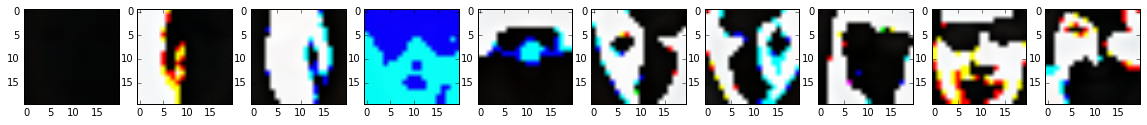

In [27]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces.
num_faces = 10
plt.figure(figsize=(20,10))
for i in range(1, num_faces+1):
    img = iterative_eigenvectors[i - 1]
    plt.subplot(2, 10, i)
    plt.imshow(np.array(img).reshape(rgb_image_shape))
# ====================================================

SVD generated eigenfaces:

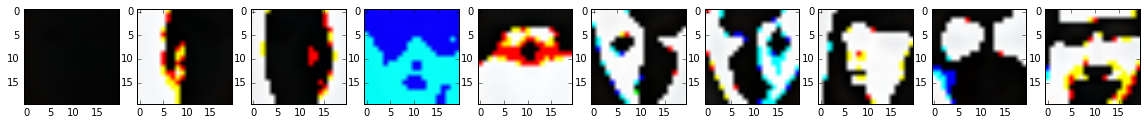

In [29]:
plot_eigenfaces(eigenvectors)